## Imports

In [1]:
import topopy
from topopy.tests.test_functions import *
import matplotlib.pyplot as plt
import samplers
import seaborn as sns
from matplotlib import patches, collections

## Setup Variables for Testing

In [23]:
# Look at topopy.tests.test_functions for different examples
test_function = gerber_different_heights

# This is the number of samples per Morse-Smale Complex, as you increase this, you should see less uncertainty in the persistence KDE plot.
samples = 50

## Helper Functions

In [3]:
def validation_grid(resolution=20, min_x = 0, max_x = 1):
    x, y = np.mgrid[min_x:max_x:(resolution * 1j), min_x:max_x:(resolution * 1j)]
    X = np.vstack([x.ravel(), y.ravel()]).T
    return x, y, X

def surface_plot(f, ax, resolution=50, samples=None, edges=None, title=None, cmap=plt.cm.cividis):
    min_x = 0
    max_x = 1
    
    x, y, X = validation_grid(resolution)
    Z = f(X)
    z = Z.reshape(x.shape)
    ax.contourf(x,y,z, cmap=cmap)
    
    if samples is not None:
        ax.scatter(samples[:, 0], samples[:, 1], s=80, linewidth=2, edgecolors="#FFFFFF", facecolors='none', zorder=2)
    if edges is not None:
        lines = []
        for edge in edges:
            lines.append([(samples[edge[0], 0], samples[edge[0], 1]),
                          (samples[edge[1], 0], samples[edge[1], 1])])
        lc = mc.LineCollection(lines, colors="#FFFFFF",
                               linewidths=1, linestyles='--', zorder=1)
        ax.add_collection(lc)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
def f(X):
    X = np.atleast_2d(X)
    Z = np.empty(X.shape[0])
    for i, xi in enumerate(X):
        Z[i] = test_function(xi)
    return Z

## Visualize Function Under Test

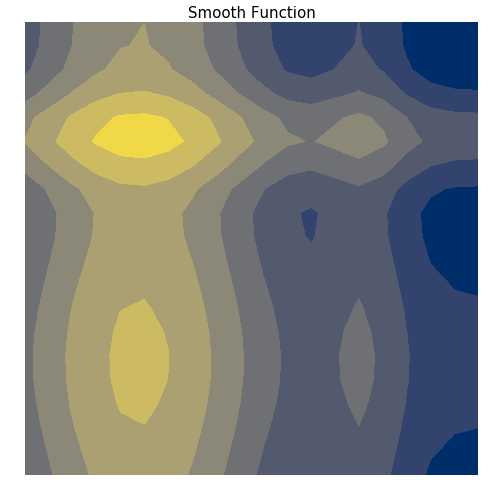

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=60)
surface_plot(f, ax, resolution=resolution, title='Smooth Function')

## Build Several Complexes Using Random Sampling

In [5]:
diagrams = []

for seed in range(100):
    X = samplers.CVTSampler.generate_samples(samples, 2, seed)
    Y = test_function(X)
    Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
    msc = topopy.MorseSmaleComplex(graph="beta skeleton", gradient="steepest", max_neighbors=8, beta=1.0)
    msc.build(X, Y)
    dgm = []
    for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
        extrema_type = msc.get_classification(extrema)
        if extrema_type == 'minimum':
            birth = Y[extrema]
            death = Y[extrema] + persistence
        else:
            birth = Y[extrema] - persistence
            death = Y[extrema]
        dgm.append((birth, death))
    diagrams.append(dgm)

## Plot All Realized Persistence Diagrams

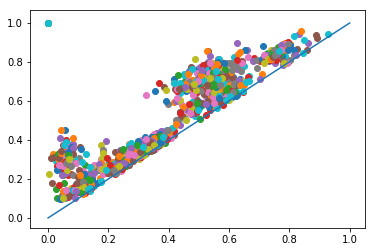

In [7]:
for dgm in diagrams:
    births = []
    deaths = []
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)
    plt.scatter(births, deaths)
plt.plot([0, 1], [0, 1])

## Some Statistical Plots of All Realized Persistence Diagrams

(0.0, 1.0)

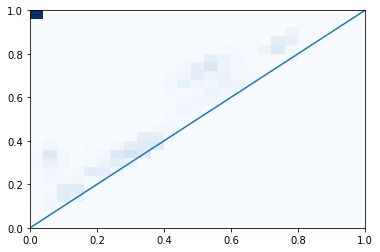

In [29]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

# Should be 0 and 1, respectively
max_value = np.max(np.hstack((births, deaths)))
min_value = np.min(np.hstack((births, deaths)))

plt.hist2d(births, deaths, bins=25, range=[[min_value, max_value], [min_value, max_value]], cmap='Blues')
plt.plot([0, max_value], [0, max_value])
plt.gca().set_xlim(min_value, max_value)
plt.gca().set_ylim(min_value, max_value)

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


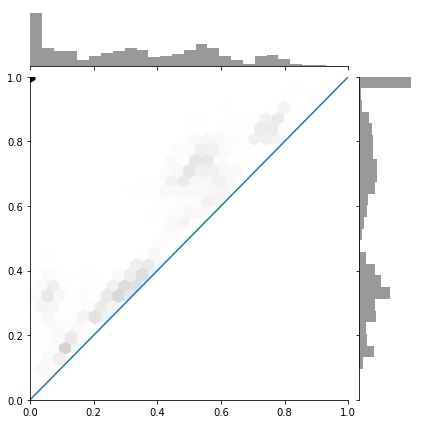

In [8]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

grid = sns.jointplot(births, deaths, joint_kws={"gridsize": 25}, marginal_kws={"bins": 25}, kind="hex", color="k", xlim=(min_value, max_value), ylim=(min_value, max_value))
grid.ax_joint.plot([0, max_value], [0, max_value])
lower_triangle = patches.Polygon([[0, 0], [max_value, max_value], [max_value, 0]])
mask = collections.PatchCollection([lower_triangle], alpha=1, color='#FFFFFF')
grid.ax_joint.add_collection(mask)

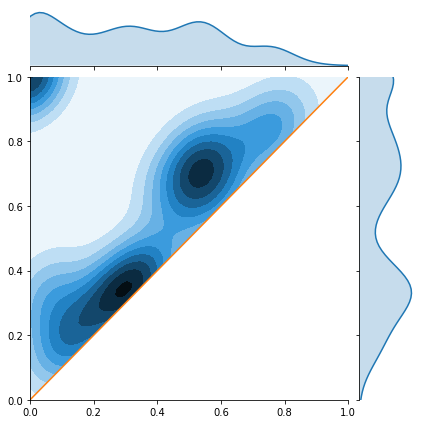

In [9]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

grid = sns.jointplot(births, deaths, kind="kde", xlim=(0, max_value), ylim=(0, max_value))
grid.ax_joint.plot([0, max_value], [0, max_value])
lower_triangle = patches.Polygon([[0, 0], [max_value, max_value], [max_value, 0]])
mask = collections.PatchCollection([lower_triangle], alpha=1, color='#FFFFFF')
grid.ax_joint.add_collection(mask)

## Generate a Ground Truth with Many More Samples

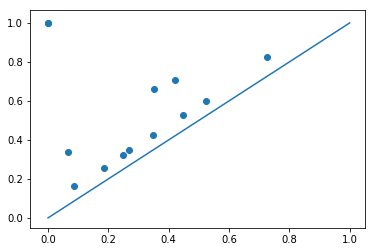

In [22]:
X = samplers.CVTSampler.generate_samples(1000, 2, seed)
Y = test_function(X)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
msc = topopy.MorseSmaleComplex(graph="beta skeleton", gradient="steepest", max_neighbors=25, beta=1.0)
msc.build(X, Y)
births = []
deaths = []
for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
    if persistence > 0.05:
        extrema_type = msc.get_classification(extrema)
        if extrema_type == 'minimum':
            birth = Y[extrema]
            death = Y[extrema] + persistence
        else:
            birth = Y[extrema] - persistence
            death = Y[extrema]

        births.append(birth)
        deaths.append(death)
        
max_value = np.max(np.hstack((births, deaths)))
        
plt.scatter(births, deaths)
plt.plot([0, max_value], [0, max_value])

## Verify the Ground Truth

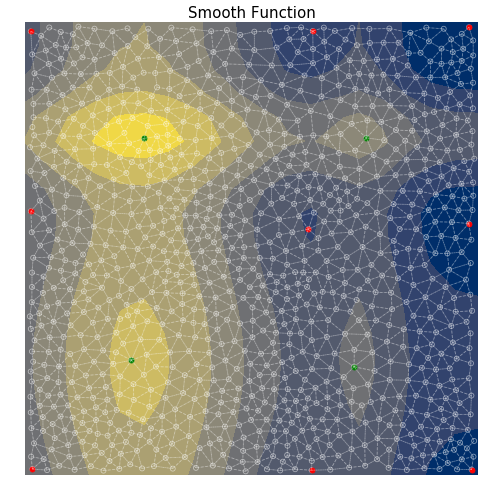

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=60)
surface_plot(f, ax, resolution=resolution, title='Smooth Function')
maxima = []
minima = []
for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
    if persistence > 0.05:
        if msc.get_classification(extrema) == 'minimum':
            minima.append(extrema)
        else:
            maxima.append(extrema)
ax.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='w', alpha=0.5)
ax.scatter(X[maxima, 0], X[maxima, 1], facecolors='g', edgecolors='g')
ax.scatter(X[minima, 0], X[minima, 1], facecolors='r', edgecolors='r')
lines = []
for i in range(len(Y)):
    neighbors = msc.get_neighbors(i)
    for j in neighbors:
        lines.append([(X[i, 0], X[i, 1]),
                      (X[j, 0], X[j, 1])])

lc = collections.LineCollection(lines, colors="#FFFFFF", linewidths=1, linestyles='--', zorder=1, alpha=0.25)
ax.add_collection(lc)